### K Neighbors Ensemble
This is an exploratory implementation of an ensemble of K Neighbors, to see if improvement in performance can be achieved 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import model_functions as mf
import feature_eng as fe
import importlib
importlib.reload(mf)
importlib.reload(fe)

<module 'feature_eng' from '/Users/yorkmacbook020/Documents/york/jenny-huang/jenny-huang-aml-student-regression/feature_eng.py'>

In [3]:
class KNEnsemble:
    def __init__(self, n_estimators = 1, n_neighbors = 5, X = None, y = None):
        self.estimators = {}
        self.features = {}
        self.data = {}
        for i in range(n_estimators):
            kn = KNeighborsRegressor(n_neighbors=n_neighbors)
            self.estimators[i] = kn
            X_train, X_test, y_train, y_test = fe.split_transform(X, y, fe.ord_trans, random_state = None)
            self.data[i] = X_train, X_test, y_train, y_test
    def fit(self):
        selectors = [SelectKBest(k = i, score_func = mutual_info_regression) for i in range (3, len(self.data[0][0].columns)+1)]
        for k, v in self.estimators.items():
            self.features[k] = mf.compare_models([v], self.data[k][0], self.data[k][1], self.data[k][2], self.data[k][3], selectors, 'relative error')['features'][0]
            print(self.features[k])
            v.fit(self.data[k][0][self.features[k]],self.data[k][2])

    def predict(self, x):
        for k, v in self.estimators.items():
            if k == 0: 
                output = np.round(v.predict(x[self.features[k]]))
            else:
                output += np.round(v.predict(x[self.features[k]]))
        #take the average of each prediction across all estimators 
        output = output/len(self.estimators)
        return output
    
    

In [4]:
X = fe.X
y = fe.y
X_train, X_test, y_train, y_test = fe.split_transform(X, y, fe.ord_trans)

In [5]:

test = KNEnsemble(5, X = X, y = y)
test.fit()

['school', 'sex', 'age', 'address', 'Medu', 'failures', 'activities', 'internet', 'romantic', 'Walc', 'absences', 'G1', 'G2', 'Talc', 'Gavg', 'social']
['G1', 'G2', 'Gavg']
['G1', 'G2', 'Gavg']
['Mjob', 'Fjob', 'address', 'Medu', 'paid', 'activities', 'nursery', 'absences', 'G1', 'G2', 'Gavg', 'social']
['age', 'absences', 'G1', 'G2', 'Gavg']


In [14]:
pred = test.predict(X_test)
print(pred)

[10.  12.2 15.   8.  10.6  3.8 12.4 15.   9.8 15.4 15.4  0.   9.4  2.6
 11.  12.  18.2 17.6 13.  10.  17.2 11.8  9.4 14.4  7.2 14.4  7.6 11.4
  5.8  9.   9.8  8.4 10.8 10.6 12.2 13.   9.6  8.6  8.   9.2 10.4 13.
 12.8 11.8 12.4 11.4 13.4 14.4 12.2 15.6 14.4  6.6  7.  18.  12.6  5.8
 13.8  4.6 13.   9.6  8.8 16.4 16.2 10.8  5.8 16.  12.2  9.2 15.   7.2
 13.2 10.   0.  10.2 13.4 16.8 15.2  2.  18.6 11.  15.  11.2 10.2  8.6
 10.   7.2  9.8 11.   0.  11.4 15.8  5.4 15.   9.2 15.2]


In [7]:
#final results 
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test,pred)
print (f"R2: {r2}, MSE: {mse}, MAE: {mae}")

R2: 0.8900119797906141, MSE: 2.3397894736842106, MAE: 0.9621052631578947


/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_72419/1326823136.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))
/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_72419/1326823136.py:7: UserWarning: The palette list has more values (20) than needed (14), which may not be intended.
  sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))


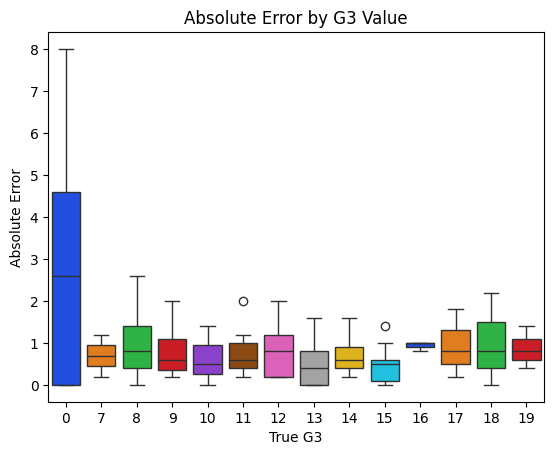

In [12]:
#show error by value 
errors = [abs(pred[i]-list(y_test)[i]) for i in range(len(pred))]
df = pd.DataFrame()
df['true'] = y_test
df['error'] = errors

sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))
plt.title("Absolute Error by G3 Value")
plt.xlabel('True G3')
plt.ylabel("Absolute Error")
plt.savefig('figures/error_vs_true_ensemble.png', bbox_inches="tight")

In [9]:
df.groupby('true').agg({'error' : 'mean'})

,error
true,
0,2.977778
7,0.700000
8,1.088889
9,0.850000
10,0.628571
11,0.760000
12,0.822222
13,0.555556
14,0.714286


In [16]:
kn = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')
features = ['absences', 'G1', 'G2', 'Gavg', 'social']	

kn.fit(X_train[features], y_train)
pred_kn = np.round(kn.predict(X_test[features]))

In [17]:
df = pd.DataFrame(columns = ['model', 'r2', 'mae'])
df.loc[0] = ['Ensemble', r2, mae]
df.loc[1] = ['Lone KN', r2_score(pred_kn, y_test), mean_absolute_error(pred_kn, y_test)]

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_72419/2781896007.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'model', y = 'r2', palette = sns.color_palette('husl', 2))


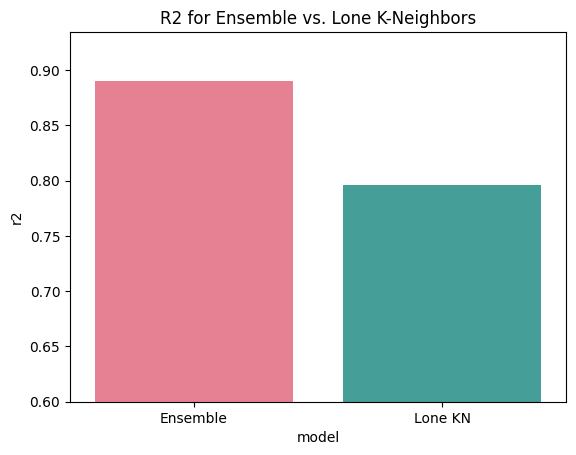

In [32]:
sns.barplot(data = df, x = 'model', y = 'r2', palette = sns.color_palette('husl', 2))
plt.ylim(0.6)
plt.title("R2 for Ensemble vs. Lone K-Neighbors")
plt.savefig('figures/r2_ensemble.png', bbox_inches="tight")

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_72419/1142068478.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'model', y = 'mae', palette = sns.color_palette('husl', 2))


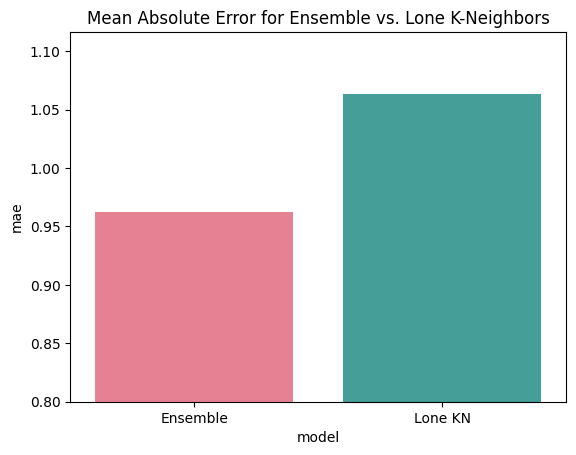

In [33]:

sns.barplot(data = df, x = 'model', y = 'mae', palette = sns.color_palette('husl', 2))
plt.ylim(0.8)
plt.title("Mean Absolute Error for Ensemble vs. Lone K-Neighbors")
plt.savefig('figures/mae_ensemble.png', bbox_inches="tight")
